# LOS prediction on MIMIC ICU patients.
exploration doc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df_los = pd.read_csv('./data/icustays_los.csv')

In [4]:
MAX_CUT_OFF = 10
MIN_CUT_OFF = 0.5
df_los = df_los[df_los.los.notnull()]
df_los = df_los[df_los.los>MIN_CUT_OFF]
df_los = df_los[df_los.los<MAX_CUT_OFF]

count    49948.000000
mean         2.745227
std          2.069091
min          0.501000
25%          1.185975
50%          2.031450
75%          3.558725
max          9.999600
Name: los, dtype: float64


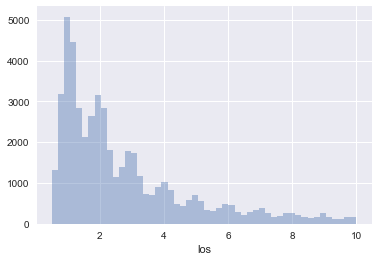

In [90]:
print(df_los.los.describe())
sns.distplot(df_los.los,  kde=False)
plt.savefig('./img/los_histogram.jpg')

In [6]:
NUM_CATEGORIES = 10
MAX_FEAT_LENGTH = 5
MIN_NUM_HOURS ,  MAX_NUM_HOURS = 24, 240 # min 1 day , max 10 days

In [58]:
df_feats = pd.read_csv('./data/adult_icustays_10kIds_selectedfeats.csv')
df_feats = df_feats[df_feats.num_hours>=0]
df_feats['num_days'] = (df_feats['num_hours']//24).astype(int)
los_per_encounter = df_feats.groupby(['icustay_id'])['num_days'].max()
df_feats['num_days_remaining'] = df_feats.apply(lambda row: (los_per_encounter[row['icustay_id']] - row['num_days']), axis=1)
targets = df_feats.groupby('icustay_id')['num_hours'].max().reset_index()
targets = targets[((targets.num_hours>=MIN_NUM_HOURS) & (targets.num_hours<=MAX_NUM_HOURS)) ]['icustay_id']
df_feats = df_feats[df_feats.icustay_id.isin(targets)]
#df_feats['num_hours_binned'] = df_feats['num_hours'].apply(lambda x: x// MAX_FEAT_LENGTH)

feats = {
    "Heart Rate": 'HR',
    "Arterial BP [Systolic]" : 'S_BP',
    "Arterial BP [Diastolic]" : 'D_BP',
    "Arterial Blood Pressure systolic" : 'S_BP',
    "Arterial Blood Pressure diastolic" : 'D_BP',
    "ETCO2" : 'EtCO2',
    "FIO2" : 'FiO2',
    "EtCO2" : 'EtCO2',
    "FiO2" : 'FiO2',
    "GCS Total" : 'GCS',
    "Blood Glucose" : 'Glucose',
    "O2 saturation pulseoxymetry" : 'SpO2',
    "Temperature F" : 'Temp',
    "Arterial pH" : 'pH',
    "SpO2" : 'SpO2',
    "Art.pH" : 'pH',
    "Respiratory Rate" : 'RR',
}

feat_normalization = {
    # Feat: (Min, Max)
    'HR': (0,200),
    'S_BP' : (0,200),
    'D_BP' : (0,200),
    'EtCO2' : (0,200),
    'FiO2' : (0,100),
    'GCS'  : (3,15),
    'Glucose' : (0,100),
    'SpO2' : (0,100),
    'Temp' : (90,110),
    'pH' : (0,14),
    'RR' : (0,100)
}

In [59]:
def normalize(x, x_min, x_max ):
    return (x-x_min)/(x_max-x_min)

df_feats = df_feats[df_feats['label'].isin(feats.keys())]
df_feats['label'] = df_feats['label'].apply(lambda x: feats[x])
df_feats['amt'] = df_feats.apply(lambda row: normalize(row['amount']
                                                       , feat_normalization[row['label']][0]
                                                      , feat_normalization[row['label']][1]
                                                      ), axis=1)

In [80]:
df_feats['num_hours_binned'] = df_feats['num_hours'].apply(lambda x: x// 12)

In [81]:
df_pivot = df_feats.groupby(['icustay_id','num_hours_binned','num_days_remaining','first_admit_age','label'])['amt'].mean()\
			.reset_index()\
			.pivot_table(index=['icustay_id','num_hours_binned','num_days_remaining', 'first_admit_age'],columns = 'label', values='amt')\
			.reset_index()

In [82]:
df_pivot['first_admit_age'] = df_pivot['first_admit_age']/100 #normalize the age
df_pivot.describe()


label,icustay_id,num_hours_binned,num_days_remaining,first_admit_age,D_BP,FiO2,GCS,HR,RR,S_BP,SpO2,Temp,pH
count,47564.000000,47564.000000,47564.000000,47564.000000,22715.000000,2.000000,42449.000000,47483.000000,47039.000000,22714.000000,46906.000000,38418.000000,16708.000000
mean,251147.460096,4.107750,2.010092,0.631311,0.303738,0.177375,0.813651,0.428016,0.194865,0.612353,0.968461,0.419187,0.531043
std,28740.815505,3.868578,1.931850,0.163976,0.059276,0.244129,0.275929,0.077861,0.046000,0.104317,0.031814,0.086285,0.138603
min,200006.000000,0.000000,0.000000,0.160200,0.020000,0.004750,0.000000,0.125000,0.040000,0.015000,0.110000,-4.025000,0.028571
25%,227064.000000,1.000000,1.000000,0.520600,0.264444,0.091062,0.645833,0.372247,0.162500,0.537917,0.957857,0.381667,0.525357
50%,251547.000000,3.000000,1.000000,0.653300,0.297083,0.177375,1.000000,0.422667,0.190000,0.600000,0.972222,0.418333,0.528571
75%,276480.000000,6.000000,3.000000,0.767000,0.337739,0.263687,1.000000,0.477778,0.221111,0.680479,0.985833,0.457500,0.531429
max,299999.000000,20.000000,10.000000,0.890000,2.131429,0.350000,1.000000,0.815156,0.670000,1.079091,1.000000,0.838333,8.106837


In [91]:
# NOT USED ANY MORE
# target is the max num_hours
#from sklearn.preprocessing import LabelEncoder
#from tensorflow.contrib.keras.python.keras.utils.np_utils import to_categorical#

##targets, categories = pd.cut(df_feats.groupby(['icustay_id'])['num_hours'].max().values, NUM_CATEGORIES, retbins=True)
#labels = LabelEncoder().fit_transform(targets)
#targets = to_categorical(labels, NUM_CATEGORIES)

In [83]:
data = []
targets = []
for icu_id in df_pivot.icustay_id.unique():
    tmp = df_pivot[df_pivot.icustay_id == icu_id]
    res = tmp[list(set(df_pivot.columns) - set(['icustay_id','num_hours_binned','num_days_remaining']))].values
    target = tmp['num_days_remaining'].values
    target = to_categorical(target, 12)
    data.append(res)
    targets.append(target)


In [84]:
data = np.asarray(data)
targets = np.asarray(targets)

In [88]:
np.save('./data/all_data.npy', data)
np.save('./data/targets.npy', targets)

In [113]:
df_pivot.num_hours_binned.max()

48

In [23]:
(df_feats.num_hours/24).describe()

count    2.719086e+06
mean     2.074210e+00
std      1.927447e+00
min     -4.583333e-01
25%      6.250000e-01
50%      1.500000e+00
75%      2.958333e+00
max      1.000000e+01
Name: num_hours, dtype: float64

In [43]:
df_feats.groupby(['num_days_remaining']).size()

num_days_remaining
0     328722
1     799171
2     542047
3     361007
4     243534
5     169921
6     118264
7      77627
8      46818
9      25438
10       710
dtype: int64